<a href="https://colab.research.google.com/github/sergiolucero/notebooks/blob/main/ETV.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

## Illustrating ETV
For every data case, we will tell the story of Extraction, Transformation and Visualization. Ideally: autos, bicis, gas, renam, ...

In [4]:
!pip install dask[dataframe]
import dask.dataframe as dd # for RENAM
import pandas as pd


##1.2 Bikes
We hacked the url that feeds the map for Bici Las Condes, transform the data and visualize a map

In [9]:
import requests
url = 'https://www.bicilascondes.cl/availability_map/getJsonObject'
bdf = pd.read_json(url)
bdf.sample(3)

,id,district,lon,lat,bikes,slots,zip,address,addressNumber,nearbyStations,status,name
7,8,LCN,-70.586035,-33.414543,2,16,NaN,NaN,NaN,"7,30",OPN,008 APOQUINDO / HANS C. ANDERSEN
12,13,LCN,-70.588140,-33.420165,4,13,NaN,NaN,NaN,"12,14",OPN,013 PDTE. ERRAZURIZ / ALCANTARA
96,99,LCN,-70.529415,-33.416379,4,11,NaN,NaN,NaN,None,OPN,099 VITAL APOQUINDO / LA QUEBRADA


In [10]:
bdf = bdf[['id','name','lat','lon','bikes','slots','status']]
bdf['color'] = bdf.apply(lambda row: 'red' if (row['bikes']<3 or row['slots']<3) \
                         else ('black' if row['status']=='CLS' else 'blue'), axis=1)
bdf.sample(3)

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  


,id,name,lat,lon,bikes,slots,status,color
70,72,072 CRISTOBAL COLON (ROTONDA ATENAS ORIENTE),-33.417995,-70.551957,5,12,OPN,blue
14,15,015 SANCHEZ FONTECILLA / MARTIN DE ZAMORA,-33.424639,-70.592543,4,16,OPN,blue
5,6,006 REYES LAVALLE (CENTRO CIVICO),-33.415801,-70.595822,5,16,OPN,blue


In [11]:
import folium
centroid = bdf[['lat','lon']].mean()
fm = folium.Map(location=centroid, width=1000, height=600, zoom_start=13)
for _, row in bdf.iterrows():
  folium.Marker(location=[row['lat'],row['lon']], 
                icon=folium.Icon(color=row['color']),
                popup = '%s (%d bicis + %d candados)' %(row['name'],row['bikes'],row['slots'])
                ).add_to(fm)    # TO DO: MAKE ICON; HOVER INFO
fm

## 1.1 Autos
Scraping of the website at chileautos.cl provided us with a handy database of 
thousands of vehicles (about 73500 of them) with plenty of info about each.

In [12]:
url1 = 'http://quant.cl/static/DATA/AUTOS/chileautos.csv.gz'
adf = pd.read_csv(url1)
print(len(adf))
adf.sample(3)

73548


,precio,Vehículo,Kilometraje,Color_Exterior,Transmisión,Puertas,Pasajeros,Litros_(motor),Cilindros,Combustible,Consumo,Región,Ciudad,Modelo,Marca,Ano_Modelo,Grupo_de_Modelos,ConsumoUrbano,País_de_fabricación,Segmento_global_JATO,Segmento_local,Tipo_de_vehículo,generación_del_modelo,PotenciaHP,ModeloMarca
24132,950000,2018 Trailer HECHIZO CARRO PORTABINS,-1,NaN,NaN,NaN,NaN,NaN,NaN,Otros,NaN,Valparaíso,La Calera,HECHIZO,Trailer,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,HECHIZO_Trailer
68661,31250000,2012 John Deere 7280R Doble Rodado,0,NaN,NaN,NaN,NaN,NaN,NaN,Diesel (petróleo),NaN,RM,Santiago,7280R,John Deere,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,7280R_John Deere
48513,1200000,1987 Toyota CORONA 1.8,10000,NaN,manual,4.0,NaN,NaN,NaN,Bencina,km/l,Maule,Talca,NaN,TOYOTA,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [13]:
adf3 = adf.groupby('Marca').agg({'precio':['min','median','max']})
adf3

precio                      
                 min      median       max
Marca                                     
ACADIAN      2500000   2500000.0   2500000
ACURA              1   4250000.0  19990000
ALFA               1   8600000.0  14500000
ALFA ROMEO   1400000   7645000.0  14400000
AMC          3500000   3500000.0   3500000
...              ...         ...       ...
ZOTYE        2000000   3700000.0   4780000
ZXAUTO         15000   3750000.0   5190000
Zetor        3500000   3500000.0   6500000
Zhongtong   15000000  38000000.0  45000000
Zodiac        770000   3800000.0  14900000

[543 rows x 3 columns]

In [17]:
# Clearly some ridiculously lower priced cars must be eliminated! 1MM CLP = 12'500 USD.
adf = adf[adf.precio>1000000]
adf3 = adf.groupby('Marca').agg({'precio':['min','median','max','count']})
atop = adf3.sort_values(('precio','count'), ascending=False).head(10).reset_index()
atop

Marca   precio                              
                  min      median         max count
0  CHEVROLET  1050000   4750000.0  1449000000  7138
1    HYUNDAI  1100000   6990000.0   999999999  5274
2        KIA  1080000   6780000.0   215000000  4265
3     TOYOTA  1100000   6900000.0    37500000  3998
4     NISSAN  1100000   7600000.0   120480000  3953
5     SUZUKI  1080000   5250000.0    96000000  3670
6    PEUGEOT  1100000   6670000.0   142000000  3328
7       FORD  1100000   9900000.0  1111111111  3081
8        BMW  1500000  12350000.0   999999999  2504
9      MAZDA  1100000   7200000.0    49500000  2431

ValueError: ignored

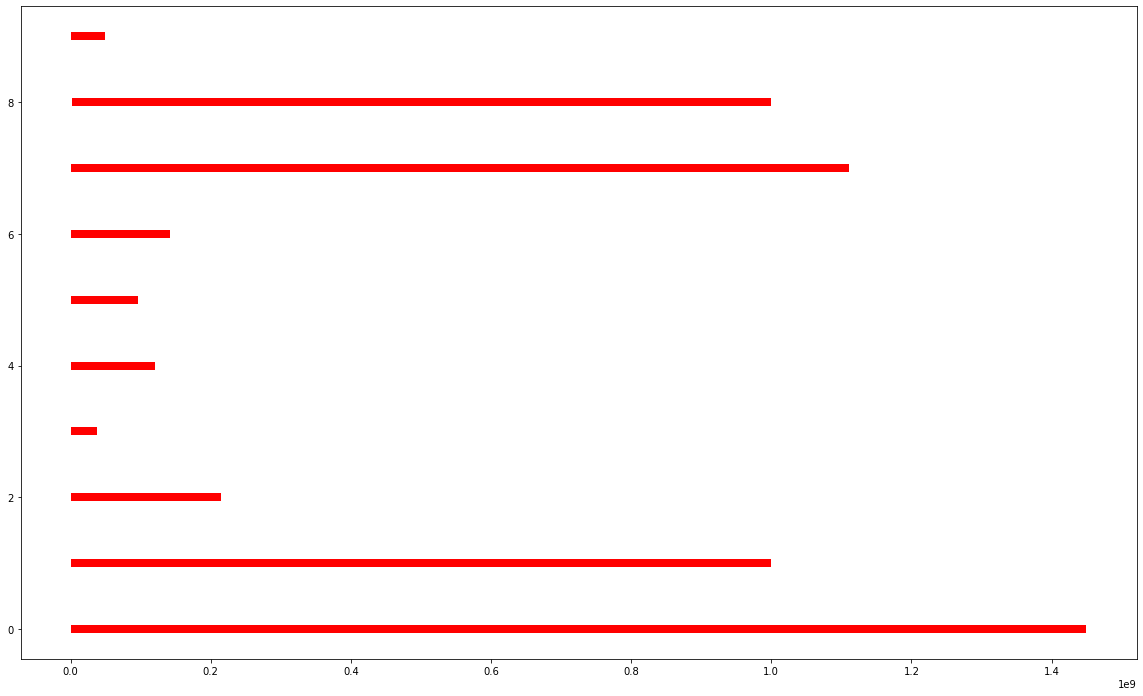

In [32]:
import matplotlib.pyplot as plt
import seaborn as sns
fig = plt.figure(figsize=(20,12))
#plt.hlines(y=atop.index,
#           xmin=atop[('precio','min')], xmax = atop[('precio','max')], 
#           lw=8, color='red') 
#plt.text(s=atop['Marca'].values,y=atop.index, x=atop[('precio','median')].values)
sns.barplot(atop, x=('precio','max'), y=atop.index)

## 1.3 Gas Prices
Extraction from CNE website, cleanup, violins.

In [37]:
url3 = 'http://quant.cl/static/DATA/ENERGIA/gas.csv'
gdf = pd.read_csv(url3)
gdf.sample(3)

,fecha,id_region,gas93,gas95,gas97,glp,gnc,diesel
147,2018-05-27 15:31:50,13,770.663830,796.855491,831.789474,445.769231,525.833333,566.936782
3,20180601,4,795.877027,827.652000,863.870000,461.166667,NaN,581.570130
57,2018-05-27 14:46:11,13,770.663830,796.855491,831.789474,445.769231,525.833333,566.936782


## 1.4 RENAM
Explain!

In [39]:
url4 = 'http://quant.cl/static/DATA/RENAM/10_casas_renam.csv.gz'
rdf = pd.read_csv(url4, low_memory=False)
rdf.sample(3)

,Vivienda ID,Temperatura Interior,Temperatura Exterior,Humedad Interior,Humedad Exterior,Co2,Ruido,Pm10,Pm25,Potencia,Energia,Measured At
2650146,86.0,"17,8",NaN,51.0,NaN,792.000,35.0,NaN,NaN,NaN,NaN,22-02-2018 0:30:00
2581530,26.0,"23,4",NaN,49.0,NaN,1.233,38.0,NaN,NaN,NaN,NaN,26-01-2018 8:00:00
1468784,24.0,"12,7",NaN,83.0,NaN,1.382,36.0,NaN,NaN,NaN,NaN,26-05-2017 2:30:00


In [ ]:
# data is split 
rdf_int = rdf[rdf['Temperatura Exterior'].isna()]
rdf_ext = rdf[rdf['Temperatura Interior'].isna()]
rdf2 = rdf_int.merge(rdf_ext, on=['Vivienda ID','Measured At'])
print(len(rdf),len(rdf2))

In [1]:
rdf_int.join?

Object `rdf_int.join` not found.


In [25]:
atop.index

RangeIndex(start=0, stop=10, step=1)

In [27]:
atop['Marca'].values

array(['CHEVROLET', 'HYUNDAI', 'KIA', 'TOYOTA', 'NISSAN', 'SUZUKI',
       'PEUGEOT', 'FORD', 'BMW', 'MAZDA'], dtype=object)

In [29]:
s=atop['Marca']
y=atop.index
x=atop[('precio','median')].values

In [31]:
list(zip(x,y,s))

[(4750000.0, 0, 'CHEVROLET'),
 (6990000.0, 1, 'HYUNDAI'),
 (6780000.0, 2, 'KIA'),
 (6900000.0, 3, 'TOYOTA'),
 (7600000.0, 4, 'NISSAN'),
 (5250000.0, 5, 'SUZUKI'),
 (6670000.0, 6, 'PEUGEOT'),
 (9900000.0, 7, 'FORD'),
 (12350000.0, 8, 'BMW'),
 (7200000.0, 9, 'MAZDA')]

In [ ]:
%debug

> /usr/local/lib/python3.7/dist-packages/pandas/core/generic.py(1538)__nonzero__()
   1536     def __nonzero__(self):
   1537         raise ValueError(
-> 1538             f"The truth value of a {type(self).__name__} is ambiguous. "
   1539             "Use a.empty, a.bool(), a.item(), a.any() or a.all()."
   1540         )

ipdb> up
> /usr/local/lib/python3.7/dist-packages/matplotlib/text.py(1165)set_text()
   1163         if s is None:
   1164             s = ''
-> 1165         if s != self._text:
   1166             self._text = str(s)
   1167             self.stale = True

ipdb> self._text
''
ipdb> up
> /usr/local/lib/python3.7/dist-packages/matplotlib/text.py(153)__init__()
    151 
    152         self._text = ''
--> 153         self.set_text(text)
    154         self.set_color(color)
    155         self.set_usetex(usetex)

ipdb> text
0    CHEVROLET
1      HYUNDAI
2          KIA
3       TOYOTA
4       NISSAN
5       SUZUKI
6      PEUGEOT
7         FORD
8          BMW
9        M

## 1.5 TGR
The local tax office gave us some data on user service times.

In [4]:
import pandas as pd
url5 = 'http://quant.cl/static/DATA/TGR/atencion20K.csv'
tdf = pd.read_csv(url5)
tdf.sample(3)

,IdOficina,Oficina,Fecha,Hora_Emi,Hora,Hora_Ate_Ini,Hora_Ate_Inicial,Hora_Ate_Fin,Perdido,Tiempo_Espera,Tiempo_Esp_Min,Tiempo_Atencion,Tiempo_Ate_Min,Total_Minutos,Ejecutivo
12752,17,TGR Talca,2018-03-28,10:05:01,10,10:05:34,10.0,10:20:43,N,33.0,0.550000,909.0,15.150000,15.70,Sergio Sepulveda Barros
279,14,TGR Viña del mar,2018-03-12,12:06:00,12,12:21:52,12.0,12:29:30,N,953.0,15.883333,458.0,7.633333,23.52,Carmen Gloria Sanchez Vega
12977,17,TGR Talca,2018-03-29,11:12:54,11,11:26:44,11.0,11:28:26,N,830.0,13.833333,102.0,1.700000,15.53,Paula Monsalves


## 1.6 